#CNN Model – To Count Fingers And Distinguish Between Left And Right Hand

In [1]:
!pip install Kaggle

##Importing Libraries

In [22]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from skimage import io, transform
import os, glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

##Uploading Kaggle token

In [3]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


##Downloading The Dataset and Extraction

In [4]:
!kaggle datasets download -d koryakinp/fingers

 96% 349M/363M [00:04<00:00, 98.8MB/s]
100% 363M/363M [00:04<00:00, 93.1MB/s]


In [5]:
from zipfile import ZipFile
file_name = "fingers.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Extraction Completed')

Extraction Completed


In [3]:
train_images = glob.glob("/content/train/*.png")
test_images = glob.glob("/content/test/*.png")


##Data Processing

In [4]:
X_train = []
X_test = []
y_train = []
y_test = []
    
for img in train_images:
    img_read = io.imread(img)
    # Most images are already of size (128,128) but it is always better to ensure they all are
    img_read = transform.resize(img_read, (128,128), mode = 'constant')
    X_train.append(img_read)
    # The info about the number of fingers and the fact that this is a right or left hand is in two characters of the path
    y_train.append(img[-6:-4])
    
for img in test_images:
    img_read = io.imread(img)
    img_read = transform.resize(img_read, (128,128), mode = 'constant')
    X_test.append(img_read)
    y_test.append(img[-6:-4])

###Plotting few images

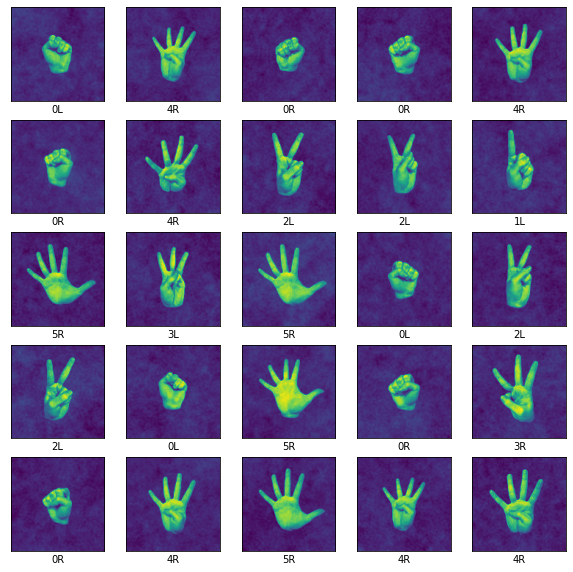

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(y_train[i])
plt.show()

In [6]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [7]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [8]:
print(X_train.shape,X_test.shape)


(18000, 128, 128, 1) (3600, 128, 128, 1)


In [9]:
label_to_int=[
    '0R',
    '1R',
    '2R',
    '3R',
    '4R',
    '5R',
    '0L',
    '1L',
    '2L',
    '3L',
    '4L',
    '5L'
]

In [10]:
temp = []
for label in y_train:
    temp.append(label_to_int.index(label))
y_train = temp.copy()

temp = []
for label in y_test:
    temp.append(label_to_int.index(label))
y_test = temp.copy()


In [11]:
y_train = keras.utils.to_categorical(y_train, num_classes = 12)
y_test = keras.utils.to_categorical(y_test, num_classes = 12)

##Model

###Model Definition

In [12]:
weight_decay = 1e-4

num_classes = 12

model = Sequential()

model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(128,128,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation="linear"))
model.add(Activation('elu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.0003), metrics=['accuracy'])
 
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1088      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      65600     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0

###Model Fit

In [13]:
history = model.fit(x = X_train,y = y_train, 
                    batch_size=64, 
                    validation_split = 0.2, 
                    epochs = 5)

Epoch 1/5
225/225 [==============================] - 75s 308ms/step - loss: 2.2314 - accuracy: 0.6965 - val_loss: 17.4642 - val_accuracy: 0.0811
Epoch 2/5
225/225 [==============================] - 71s 316ms/step - loss: 0.0461 - accuracy: 0.9996 - val_loss: 3.7570 - val_accuracy: 0.1894
Epoch 3/5
225/225 [==============================] - 71s 316ms/step - loss: 0.0424 - accuracy: 0.9999 - val_loss: 0.0569 - val_accuracy: 0.9983
Epoch 4/5
225/225 [==============================] - 71s 315ms/step - loss: 0.0409 - accuracy: 1.0000 - val_loss: 0.0408 - val_accuracy: 1.0000
Epoch 5/5
225/225 [==============================] - 71s 315ms/step - loss: 0.0402 - accuracy: 1.0000 - val_loss: 0.0397 - val_accuracy: 1.0000


##Plotting Loss and Accuracy of model over epochs

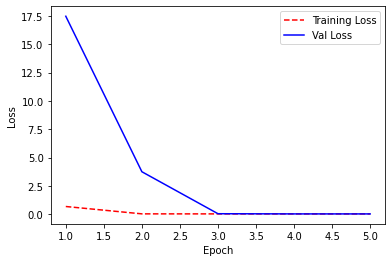

In [14]:
# Get training and test loss histories
training_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

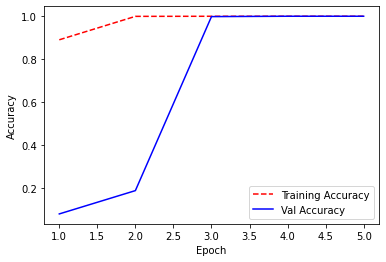

In [15]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

##Model Evalutation

In [16]:
# Evaluate the model on test set
score = model.evaluate(X_test, y_test)

# Print test accuracy
print( 'Test accuracy:', score[1]*100)

113/113 [==============================] - 5s 43ms/step - loss: 0.0400 - accuracy: 1.0000
Test accuracy: 100.0


##Plotting Test Images

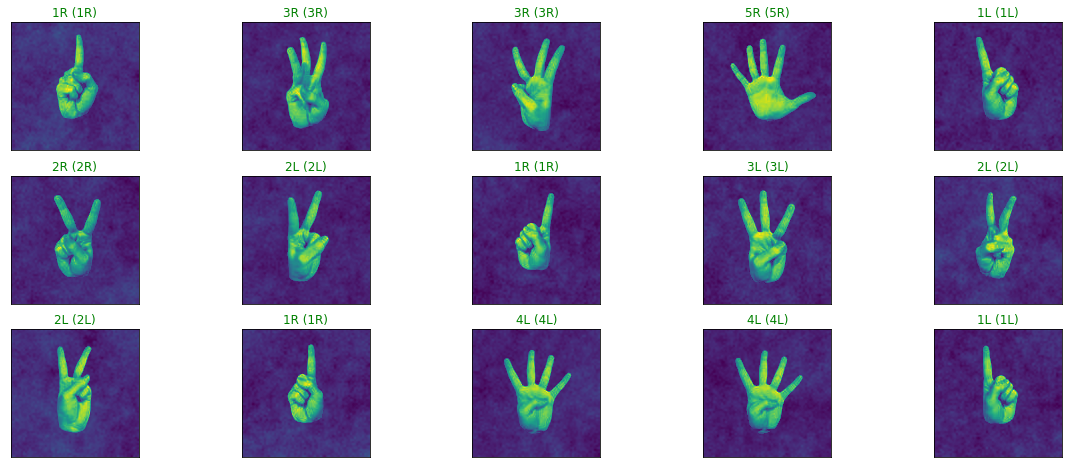

In [17]:
y_hat = model.predict(X_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(label_to_int[predict_index], 
                                  label_to_int[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

##Confusion Matrix

In [31]:
pred = [np.argmax(y_hat[i]) for i in range(len(y_hat))]
truel = [np.argmax(y_test[i]) for i in range(len(y_test))]


[1, 4, 3, 11, 4]


In [36]:
cm=confusion_matrix(truel,pred)
print(cm)

[[300   0   0   0   0   0   0   0   0   0   0   0]
 [  0 300   0   0   0   0   0   0   0   0   0   0]
 [  0   0 300   0   0   0   0   0   0   0   0   0]
 [  0   0   0 300   0   0   0   0   0   0   0   0]
 [  0   0   0   0 300   0   0   0   0   0   0   0]
 [  0   0   0   0   0 300   0   0   0   0   0   0]
 [  0   0   0   0   0   0 300   0   0   0   0   0]
 [  0   0   0   0   0   0   0 300   0   0   0   0]
 [  0   0   0   0   0   0   0   0 300   0   0   0]
 [  0   0   0   0   0   0   0   0   0 300   0   0]
 [  0   0   0   0   0   0   0   0   0   0 300   0]
 [  0   0   0   0   0   0   0   0   0   0   0 300]]


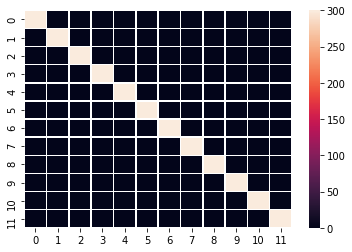

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

cm = np.array(cm)
ax = sns.heatmap(cm, linewidth=0.5)
plt.show()

##Saving The Model






In [18]:
model.save("fingerscount")


INFO:tensorflow:Assets written to: fingerscount/assets
